In [33]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])
from jax import vjp, linearize, grad
from functools import partial


In [34]:
def get_exact_inverse(X, Y_star, reg_factor):
    f = partial(regularized_KL_divergence, reg_factor=reg_factor)
    dy, H, J = d_y_star_d_x_outer(f, X, Y_star)
    L, lower = jax.scipy.linalg.cho_factor(H, lower=True)
    u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
    L_t, lower = jax.scipy.linalg.cho_factor(H, lower=False)
    H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
    return H_inv

In [21]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
#X, y = make_blobs(n_samples=50, n_features=10, centers=1, random_state=0, shuffle=False)
key = random.PRNGKey(41)

#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9299, 50 iterations in 0.9993 sec
Iteration  100, KL divergence 0.9668, 50 iterations in 0.7844 sec
Iteration  150, KL divergence 1.0012, 50 iterations in 0.7042 sec
Iteration  200, KL divergence 0.9940, 50 iterations in 0.6621 sec
Iteration  250, KL divergence 0.9405, 50 iterations in 0.6772 sec
   --> Time elapsed: 3.83 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1734, 50 iterations in 0.6774 sec
Iteration  100, KL divergence 0.1641, 50 iterations in 0.6707 sec
Iteration  150, KL divergence 0.1641, 50 iterations in 0.6703 sec
Iteration  200, KL divergence 0.1641, 50 iterations in 0.6860 sec
Iteration 

# Cosine similarity and l2 Distance

In [39]:
reg_factor = 0.001

In [40]:
H_inv = get_exact_inverse(X, Y_star, reg_factor)   # Exact Inverse

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [42]:
H_inv_approx = get_Neumann_approximation(X_flat, X_unflattener, 
                                         Y_flat, Y_unflattener, 
                                         reg_factor = reg_factor, 
                                         neumann_iterations=800)   # Approximation

Computing pairwise distances...
Starting binary search
Entered binary search function


In [37]:
l2_dist = lambda x: np.linalg.norm(x - H_inv)
l2_dist(H_inv_approx)

Array(56372.457, dtype=float32)

<AxesSubplot: >

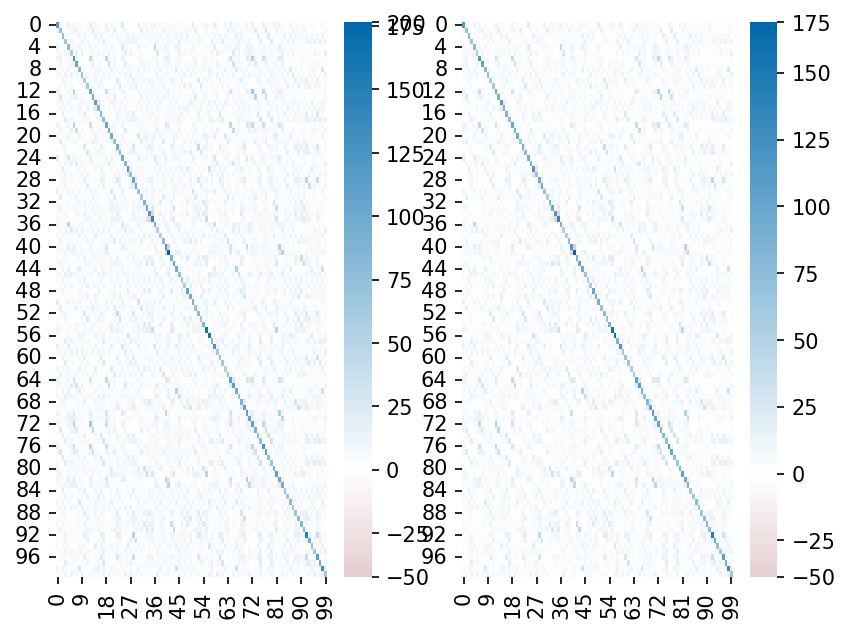

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv), vmax=np.max(H_inv))), ax=ax1)
sns.heatmap(H_inv_approx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv_approx), vmax=np.max(H_inv_approx))), ax=ax2)

In [ ]:
iterations = 500
dists = []
for i in range(1, iterations, 50):
    v_in = np.eye(len(Y_flat))
    neumann_fun = lambda x: neumannApproximation_vis(f_vjp, x, Y_flat, i)
    H_inv_appr = vmap(neumann_fun)(v_in)
    dists.append(l2_dist(H_inv_appr))

In [ ]:
f = plt.figure()
plt.scatter(range(1, iterations, 50), dists)
plt.ylabel('norm')
plt.xlabel('Neumann iterations')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv), vmax=np.max(H_inv))), ax=ax1)
sns.heatmap(H_inv_appr, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv_appr), vmax=np.max(H_inv_appr))), ax=ax2)

In [ ]:
f = plt.figure()
sns.heatmap(J, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J), vmax=np.max(J))))

In [ ]:
f = plt.figure()
sns.heatmap(dy, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy), vmax=np.max(dy))))

# Regularization

In [12]:
# Approximation
reg_factors = [0.001, 0.0001, 0.00001]
H_invs = []
for i in reg_factors:
    fun = lambda x: regularized_KL_divergence(X_flat, x, X_unflattener, Y_unflattener, i)
    _, f_vjp = vjp(grad(fun), Y_flat)
    v_in = np.eye(len(Y_flat))
    neumann_fun = lambda x: neumannApproximation_vis(f_vjp, x, Y_flat, 500)
    H_inv_appr = vmap(neumann_fun)(v_in)
    H_invs.append(H_inv_appr)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

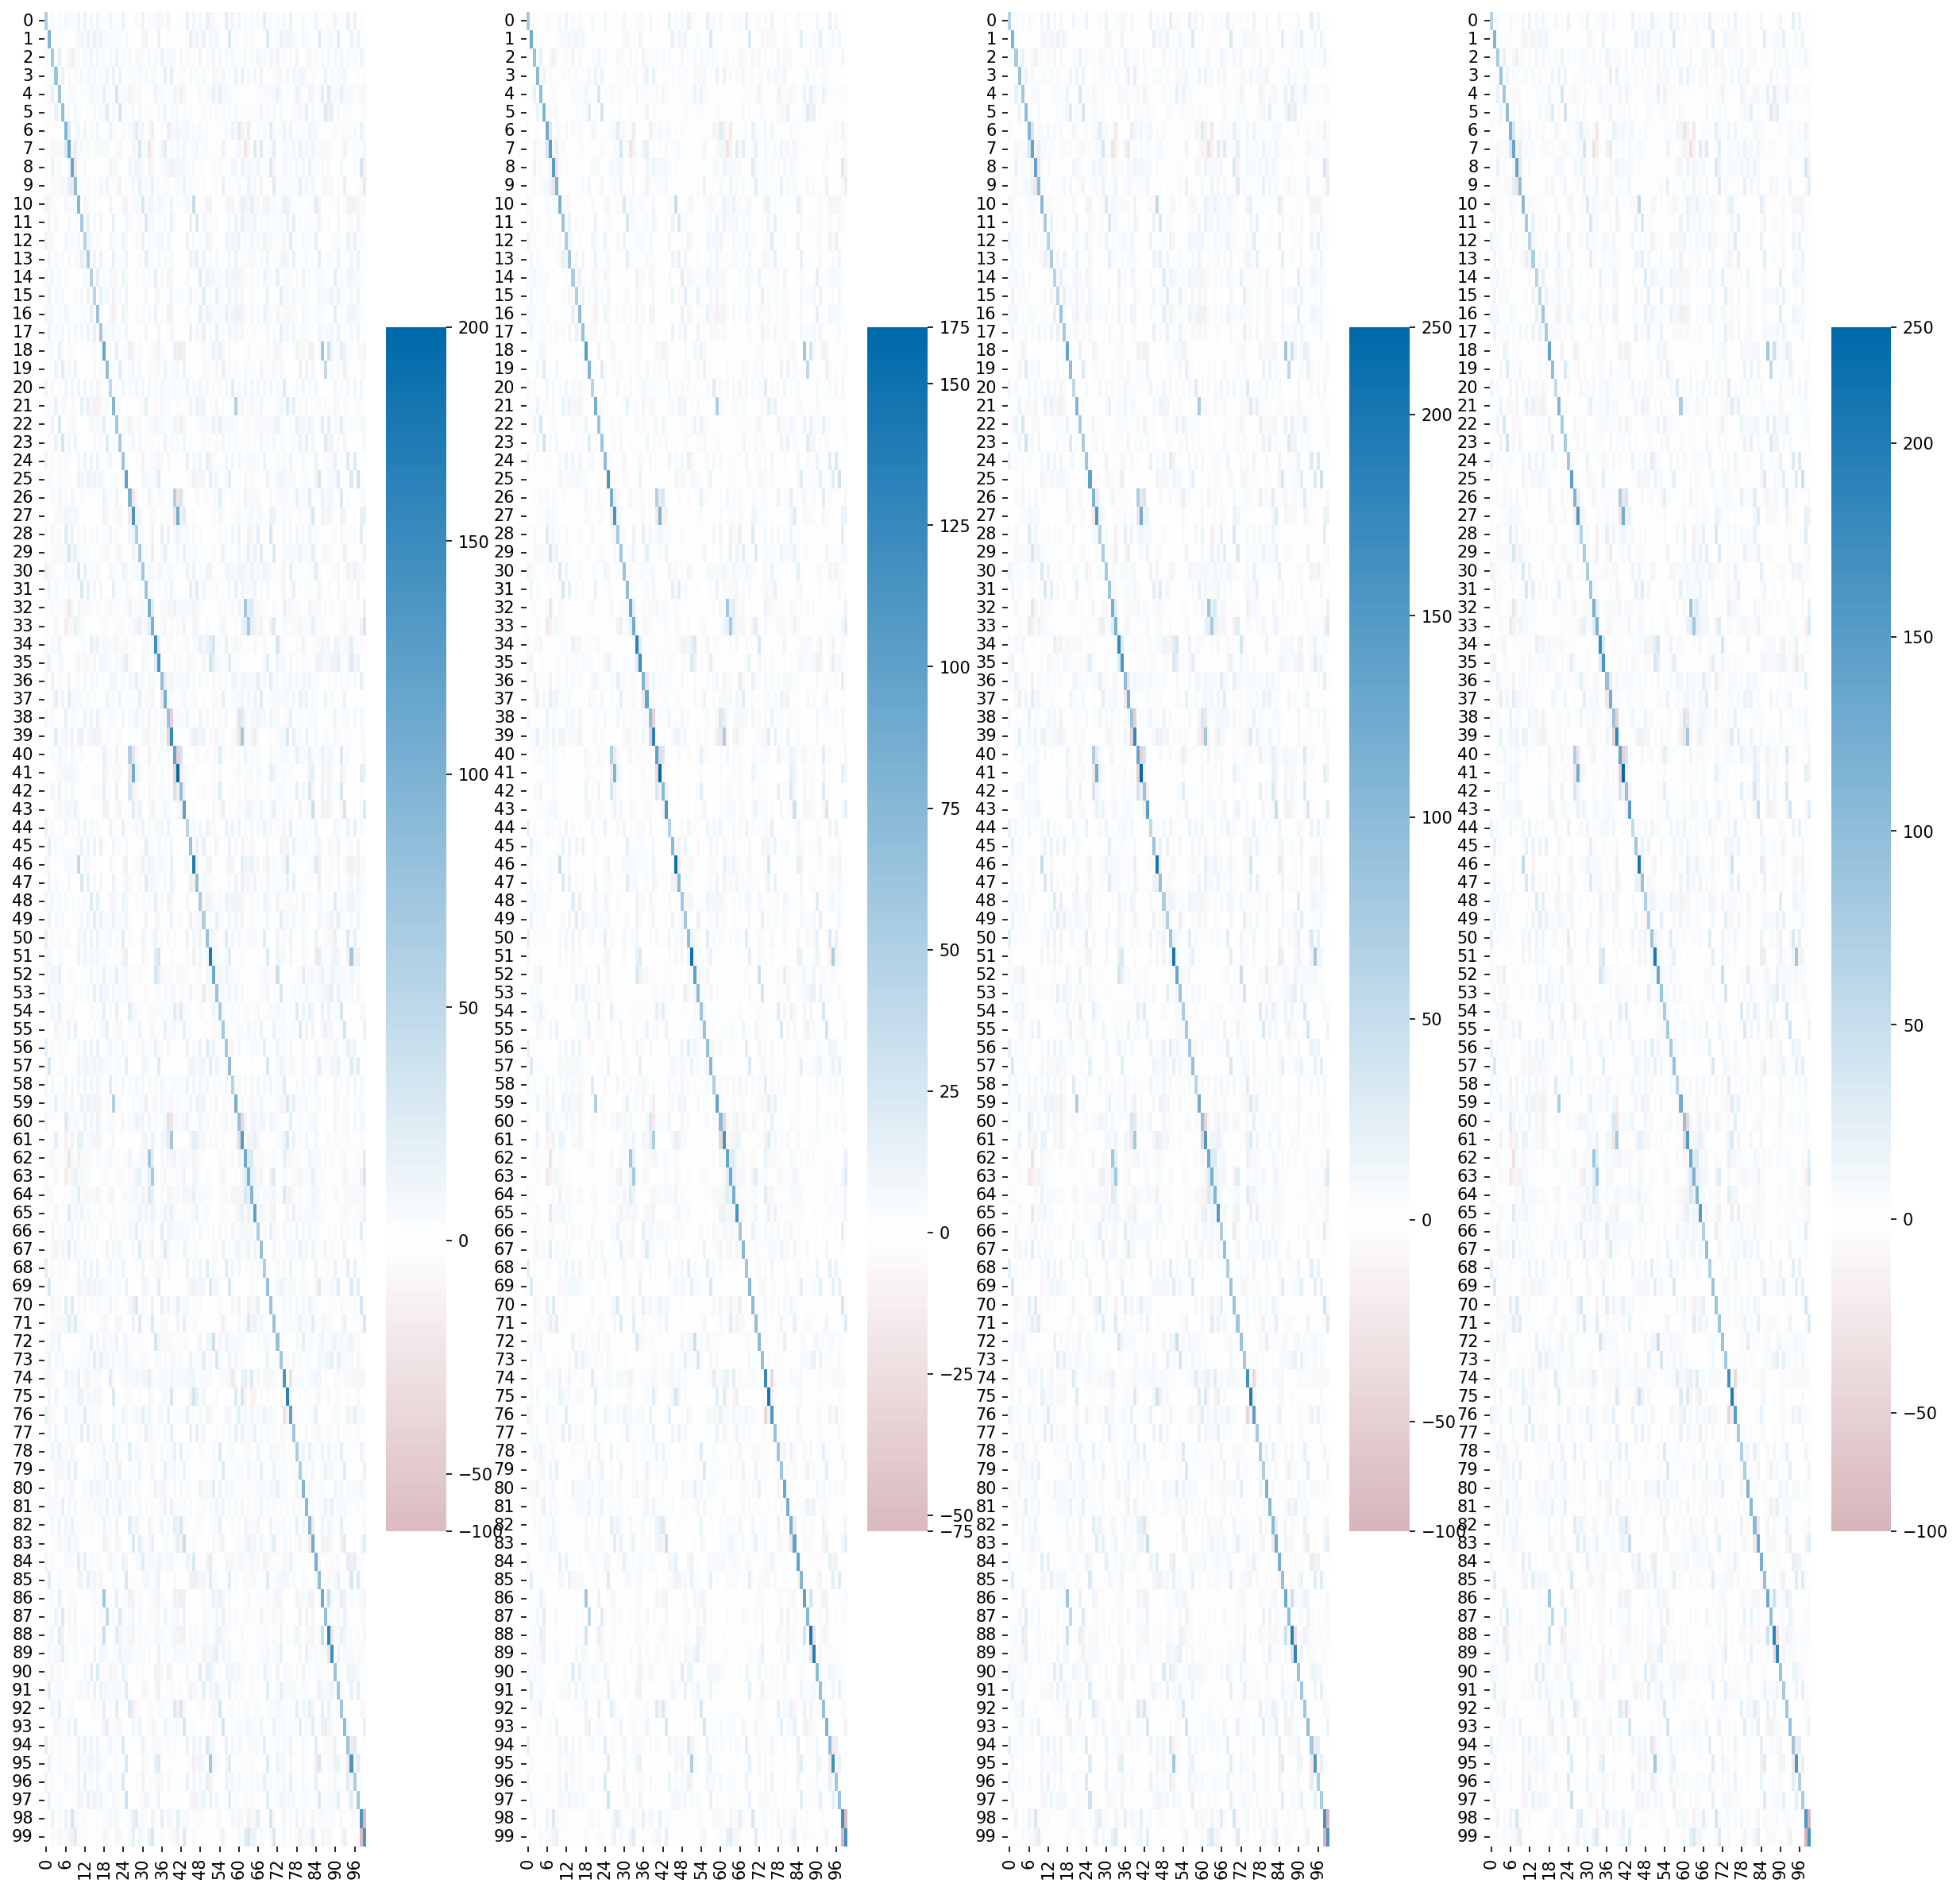

In [14]:
f, (ax_true, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 20))
sns.heatmap(H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv), vmax=np.max(H_inv))), ax=ax_true)
sns.heatmap(H_invs[0], cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_invs[0]), vmax=np.max(H_invs[0]))), ax=ax1)
sns.heatmap(H_invs[1], cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_invs[1]), vmax=np.max(H_invs[1]))), ax=ax2)
sns.heatmap(H_invs[2], cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_invs[2]), vmax=np.max(H_invs[2]))), ax=ax3)